In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import time

# Auxiliary functions

In [2]:
def logdet(M):
    slogdet_M = la.slogdet(M)
    return slogdet_M[0]*slogdet_M[1]

def inv(M):
    return la.inv(M)

def tsp(M):
    return np.transpose(M)

def LSE(x):
    n = len(x)
    f = 0
    for i in range(n):
        f += np.exp(x[i])
    return np.log(f)

def LSE_m(x):
    y = x-max(x)
    return LSE(y)+max(x)

# Output classes

In [3]:
class rsfm_fit_inf():
    
    def __init__(self,likelihood,prediction,filtering,smoothing):
        self.likelihood = likelihood
        self.prediction = prediction
        self.filtering = filtering
        self.smoothing = smoothing

class rsfm_fit_out():
    
    def __init__(self,α,B,σ,p,P,observed,PLL_hist,OLL_hist,AIC,BIC):
        self.α = α
        self.B = B
        self.σ = σ
        self.p = p
        self.P = P
        self.observed = observed
        self.PLL_hist = PLL_hist
        self.OLL_hist = OLL_hist
        self.AIC = AIC
        self.BIC = BIC
        
    def save(self,filename):
        rsfm_inf = self.inference()
        np.savez(filename,alpha=self.α,beta=self.B,sigma=self.σ,p=self.p,
                 P=self.P,observed=self.observed,PLL_hist=self.PLL_hist,
                 OLL_hist=self.OLL_hist,AIC=self.AIC,BIC=self.BIC,
                 likelihood=rsfm_inf.likelihood,prediction=rsfm_inf.prediction,
                 filtering=rsfm_inf.filtering,smoothing=rsfm_inf.smoothing)
        
    def inference(self):
        
        # create matrices to store probabilities
        T = self.observed.shape[0]
        S = self.observed.shape[1]
        likelihood = self.observed
        prediction = np.zeros((T+1,S))
        filtering = np.zeros((T,S))
        smoothing = np.zeros((T,S)) 

        # compute prediction and filtering probabilities
        prediction[0,:] = self.p
        for t in range(T):
            # compute total for filtering
            log_prediction_iter = np.zeros(S)
            for s in range(S):
                log_prediction_iter[s] = np.log(max(prediction[t,s],1e-300))+likelihood[t,s]
            log_prediction_total = LSE_m(log_prediction_iter)
            # compute filtering
            for s in range(S):
                filtering[t,s] = np.exp(np.log(max(prediction[t,s],1e-300))+likelihood[t,s]-log_prediction_total)
            # compute prediction
            for s in range(S):
                for sprime in range(S):
                    prediction[t+1,s] += filtering[t,sprime]*self.P[sprime,s]

        # compute smoothing probabilities
        for t in range(T-1,0-1,-1):
            for s in range(S):
                for sprime in range(S):
                    if t == T-1:
                        smoothing[t,s] += self.P[s,sprime]*prediction[t+1,sprime]/prediction[t+1,sprime]
                    else:
                        smoothing[t,s] += self.P[s,sprime]*smoothing[t+1,sprime]/prediction[t+1,sprime]
                smoothing[t,s] = smoothing[t,s]*filtering[t,s]
        
        return rsfm_fit_inf(likelihood,prediction,filtering,smoothing)

# Fitting functions

## Factor model

In [4]:
def fm_fit(r,F):
    
    # set dimensions
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record estimates
    α = np.zeros(N)
    B = np.ones((N,M))
    σ = np.ones(N)
    p = 1
    P = 1
    observed = np.zeros(T)
    PLL_hist = 0
    OLL_hist = 0
    
    # estimate parameters
    for i in range(N):
        y = r[:,i]
        X = np.column_stack((np.ones(T),F))
        mod = sm.OLS(y,X)
        res = mod.fit()
        α[i] = res.params[0]
        B[i,:] = res.params[1:(M+1)]
        σ[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(T)
    
    Ω = np.diag(σ**2)
    for t in range(T):
        e_t = r[t,:]-α-B@F[t,:]
        observed[t] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω)-0.5*e_t@inv(Ω)@e_t
        
    PLL_hist = np.sum(observed)/T
    OLL_hist = np.sum(observed)/T
    
    AIC = -2*T*OLL_hist+2*(N+N*M+N)
    BIC = -2*T*OLL_hist+np.log(T)*(N+N*M+N)
    
    return rsfm_fit_out(α,B,σ,p,P,observed,PLL_hist,OLL_hist,AIC,BIC)

## Regime-switching factor model

In [5]:
def rsfm_fit(r,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros((S,N))
    B_best = np.ones((S,N,M))
    σ_best = np.ones((S,N))
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros((S,N))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[0],size=S*N),(S,N))
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.reshape(np.random.chisquare(df=init_noise_scale[2],size=S*N),(S,N))
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                for s in range(S):
                    α_s = α[s,:]
                    B_s = B[s,:,:]
                    Ω_s = np.diag(σ[s,:]**2)
                    for t in range(T):
                        e_st = r[t,:]-α_s-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω_s)-0.5*e_st@inv(Ω_s)@e_st
                
                # compute forward log-densities
                log_forward = np.zeros((T,S))
                for s in range(S):
                    log_forward[0,s] = np.log(max(p[s],1e-300))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iter[sprime] = log_forward[t-1,sprime]+np.log(max(P[sprime,s],1e-300))+observed[t,s]
                        log_forward[t,s] = LSE_m(log_forward_iter)

                # compute backward log-densities
                log_backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iter[sprime] = log_backward[t+1,sprime]+np.log(max(P[s,sprime],1e-300))+observed[t+1,sprime]
                        log_backward[t,s] = LSE_m(log_backward_iter) 

                # compute posterior marginal log-densities for latent variables
                log_q = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_q_total = np.zeros(S)
                        for sprime in range(S):
                            log_q_total[sprime] = log_forward[t,sprime]+log_backward[t,sprime]
                        log_q[t,s] = log_forward[t,s]+log_backward[t,s]-LSE_m(log_q_total)

                # compute posterior transition log-densities for latend variables
                log_Q = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_Q_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_Q_total[j,k] = log_forward[t,j]+np.log(max(P[j,k],100))+log_backward[t+1,k]+observed[t+1,k]
                            log_Q_total = log_Q_total.flatten()
                            log_Q[t,s,sprime] = log_forward[t,s]+np.log(max(P[s,sprime],100))+log_backward[t+1,sprime]+observed[t+1,sprime]-LSE_m(log_Q_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros((S,N))
                B_new = np.zeros((S,N,M))
                σ_new = np.zeros((S,N))
                    
                # compute new iterates
                q = np.exp(log_q)
                for s in range(S):
                    # compute total weighted probability for state s
                    q_s_total = 0
                    for t in range(T):
                        q_s_total += q[t,s]
                    # create weighted factor matrix for state s
                    φ_s = np.zeros((T,M+1))
                    for t in range(T):
                        for m in range(M+1):
                            if m == 0:
                                φ_s[t,m] = q[t,s]**0.5
                            else:
                                φ_s[t,m] = q[t,s]**0.5*F[t,m-1]
                    for i in range(N):
                        # create weighted returns for asset i in state s
                        r_tilde_si = np.zeros(T)
                        for t in range(T):
                            r_tilde_si[t] = q[t,s]**0.5*r[t,i]
                        # compute factor model parameters  
                        β_si = inv(tsp(φ_s)@φ_s)@tsp(φ_s)@r_tilde_si
                        α_new[s,i] = β_si[0]
                        B_new[s,i,:] = β_si[1:]
                        σ_new[s,i] = la.norm(r_tilde_si-φ_s@β_si)/(q_s_total**0.5)

                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # create new iterates
                p_new = q[0,:]
                P_new = np.zeros((S,S))
                
                # compute new iterates
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(log_Q[t,s,sprime])
                            dnm += np.exp(log_q[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_iter = np.zeros(S)
                    for s in range(S):
                        PLL_iter[s] = np.log(max(q[t,s],1e-300))+observed[t,s]
                    PLL_total = LSE_m(PLL_iter) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    p_t = la.matrix_power(tsp(P),t)@p
                    OLL_iter = np.zeros(S)
                    for s in range(S):
                        OLL_iter[s] = np.log(max(p_t[s],1e-300))+observed[t,s]
                    OLL_total = LSE_m(OLL_iter)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    AIC_best = -2*T*OLL_best+2*(S*N+S*N*M+S*N+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(S*N+S*N*M+S*N+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

## Alpha-restricted regime-switching factor model

In [6]:
def α_rsfm_fit(r,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros(N)
    B_best = np.ones((S,N,M))
    σ_best = np.ones((S,N))
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros(N)+np.random.normal(loc=0,scale=init_noise_scale[0],size=N)
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.reshape(np.random.chisquare(df=init_noise_scale[2],size=S*N),(S,N))
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                for s in range(S):
                    B_s = B[s,:,:]
                    Ω_s = np.diag(σ[s,:]**2)
                    for t in range(T):
                        e_st = r[t,:]-α-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω_s)-0.5*e_st@inv(Ω_s)@e_st
                
                # compute forward log-densities
                log_forward = np.zeros((T,S))
                for s in range(S):
                    log_forward[0,s] = np.log(max(p[s],1e-300))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iter[sprime] = log_forward[t-1,sprime]+np.log(max(P[sprime,s],1e-300))+observed[t,s]
                        log_forward[t,s] = LSE_m(log_forward_iter)

                # compute backward log-densities
                log_backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iter[sprime] = log_backward[t+1,sprime]+np.log(max(P[s,sprime],1e-300))+observed[t+1,sprime]
                        log_backward[t,s] = LSE_m(log_backward_iter) 

                # compute posterior marginal log-densities for latent variables
                log_q = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_q_total = np.zeros(S)
                        for sprime in range(S):
                            log_q_total[sprime] = log_forward[t,sprime]+log_backward[t,sprime]
                        log_q[t,s] = log_forward[t,s]+log_backward[t,s]-LSE_m(log_q_total)

                # compute posterior transition log-densities for latend variables
                log_Q = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_Q_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_Q_total[j,k] = log_forward[t,j]+np.log(max(P[j,k],100))+log_backward[t+1,k]+observed[t+1,k]
                            log_Q_total = log_Q_total.flatten()
                            log_Q[t,s,sprime] = log_forward[t,s]+np.log(max(P[s,sprime],100))+log_backward[t+1,sprime]+observed[t+1,sprime]-LSE_m(log_Q_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros(N)
                B_new = np.zeros((S,N,M))
                σ_new = np.zeros((S,N))
                
                # compute new iterates
                q = np.exp(log_q)
                # compute state-dependent quantities
                q_s = np.zeros((S,T))
                q_s_total = np.zeros(S)
                r_si = np.zeros((S,N,T))
                F_tilde_s = np.zeros((S,T,M))
                for s in range(S):
                    for t in range(T):
                        q_s[s,t] = q[t,s]
                        q_s_total[s] += q[t,s]
                        for i in range(N):
                            r_si[s,i,t] = q[t,s]*r[t,i]
                        for m in range(M):
                            F_tilde_s[s,t,m] = q[t,s]**0.5*F[t,m]
                # compute factor model parameters
                for i in range(N):
                    R_i = np.sum(r[:,i])
                    num_sum = 0
                    dnm_sum = 0
                    for s in range(S):
                        num_sum += tsp((tsp(F)@r_si[s,i,:]))@inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@(tsp(F)@q_s[s,:])
                        dnm_sum += tsp((tsp(F)@q_s[s,:]))@inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@(tsp(F)@q_s[s,:])
                    α_new[i] = (R_i-num_sum)/(T-dnm_sum)   
                    for s in range(S):
                        B_new[s,i,:] = inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@tsp(F)@(r_si[s,i,:]-α_new[i]*q_s[s,:])
                        WSSR_si = 0
                        for t in range(T):
                            WSSR_si += q[t,s]*(r[t,i]-α_new[i]-B_new[s,i,:]@F[t,:])**2
                        σ_new[s,i] = np.sqrt(WSSR_si/q_s_total[s])
                    
                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # create new iterates
                p_new = q[0,:]
                P_new = np.zeros((S,S))
                
                # compute new iterates
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(log_Q[t,s,sprime])
                            dnm += np.exp(log_q[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_iter = np.zeros(S)
                    for s in range(S):
                        PLL_iter[s] = np.log(max(q[t,s],1e-300))+observed[t,s]
                    PLL_total = LSE_m(PLL_iter) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    p_t = la.matrix_power(tsp(P),t)@p
                    OLL_iter = np.zeros(S)
                    for s in range(S):
                        OLL_iter[s] = np.log(max(p_t[s],1e-300))+observed[t,s]
                    OLL_total = LSE_m(OLL_iter)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    
    AIC_best = -2*T*OLL_best+2*(N+S*N*M+S*N+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(N+S*N*M+S*N+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

## Sigma-restricted regime-switching factor model

In [7]:
def σ_rsfm_fit(r,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros((S,N))
    B_best = np.ones((S,N,M))
    σ_best = np.ones(N)
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros((S,N))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[0],size=S*N),(S,N))
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.random.chisquare(df=init_noise_scale[2],size=N)
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                Ω = np.diag(σ**2)
                for s in range(S):
                    α_s = α[s,:]
                    B_s = B[s,:,:]
                    for t in range(T):
                        e_st = r[t,:]-α_s-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω)-0.5*e_st@inv(Ω)@e_st
                
                # compute forward log-densities
                log_forward = np.zeros((T,S))
                for s in range(S):
                    log_forward[0,s] = np.log(max(p[s],1e-300))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iter[sprime] = log_forward[t-1,sprime]+np.log(max(P[sprime,s],1e-300))+observed[t,s]
                        log_forward[t,s] = LSE_m(log_forward_iter)

                # compute backward log-densities
                log_backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iter[sprime] = log_backward[t+1,sprime]+np.log(max(P[s,sprime],1e-300))+observed[t+1,sprime]
                        log_backward[t,s] = LSE_m(log_backward_iter) 

                # compute posterior marginal log-densities for latent variables
                log_q = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_q_total = np.zeros(S)
                        for sprime in range(S):
                            log_q_total[sprime] = log_forward[t,sprime]+log_backward[t,sprime]
                        log_q[t,s] = log_forward[t,s]+log_backward[t,s]-LSE_m(log_q_total)

                # compute posterior transition log-densities for latend variables
                log_Q = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_Q_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_Q_total[j,k] = log_forward[t,j]+np.log(max(P[j,k],100))+log_backward[t+1,k]+observed[t+1,k]
                            log_Q_total = log_Q_total.flatten()
                            log_Q[t,s,sprime] = log_forward[t,s]+np.log(max(P[s,sprime],100))+log_backward[t+1,sprime]+observed[t+1,sprime]-LSE_m(log_Q_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros((S,N))
                B_new = np.zeros((S,N,M))
                σ_new = np.zeros(N)
                    
                # compute new iterates
                q = np.exp(log_q)
                for s in range(S):
                    # compute total weighted probability for state s
                    q_s_total = 0
                    for t in range(T):
                        q_s_total += q[t,s]
                    # create weighted factor matrix for state s
                    φ_s = np.zeros((T,M+1))
                    for t in range(T):
                        for m in range(M+1):
                            if m == 0:
                                φ_s[t,m] = q[t,s]**0.5
                            else:
                                φ_s[t,m] = q[t,s]**0.5*F[t,m-1]
                    for i in range(N):
                        # create weighted returns for asset i in state s
                        r_tilde_si = np.zeros(T)
                        for t in range(T):
                            r_tilde_si[t] = q[t,s]**0.5*r[t,i]
                        # compute factor model parameters  
                        β_si = inv(tsp(φ_s)@φ_s)@tsp(φ_s)@r_tilde_si
                        α_new[s,i] = β_si[0]
                        B_new[s,i,:] = β_si[1:]
                        σ_new[i] += la.norm(r_tilde_si-φ_s@β_si)**2
                for i in range(N):
                    σ_new[i] = np.sqrt(σ_new[i]/T)

                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # create new iterates
                p_new = q[0,:]
                P_new = np.zeros((S,S))
                
                # compute new iterates
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(log_Q[t,s,sprime])
                            dnm += np.exp(log_q[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_iter = np.zeros(S)
                    for s in range(S):
                        PLL_iter[s] = np.log(max(q[t,s],1e-300))+observed[t,s]
                    PLL_total = LSE_m(PLL_iter) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    p_t = la.matrix_power(tsp(P),t)@p
                    OLL_iter = np.zeros(S)
                    for s in range(S):
                        OLL_iter[s] = np.log(max(p_t[s],1e-300))+observed[t,s]
                    OLL_total = LSE_m(OLL_iter)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    
    AIC_best = -2*T*OLL_best+2*(S*N+S*N*M+N+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(S*N+S*N*M+N+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

## Alpha- and sigma-restricted regime-switching factor model

In [8]:
def ασ_rsfm_fit(r,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros(N)
    B_best = np.ones((S,N,M))
    σ_best = np.ones(N)
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros(N)+np.random.normal(loc=0,scale=init_noise_scale[0],size=N)
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.random.chisquare(df=init_noise_scale[2],size=N)
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                Ω = np.diag(σ**2)
                for s in range(S):
                    B_s = B[s,:,:]
                    for t in range(T):
                        e_st = r[t,:]-α-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω)-0.5*e_st@inv(Ω)@e_st
                
                # compute forward log-densities
                log_forward = np.zeros((T,S))
                for s in range(S):
                    log_forward[0,s] = np.log(max(p[s],1e-300))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iter[sprime] = log_forward[t-1,sprime]+np.log(max(P[sprime,s],1e-300))+observed[t,s]
                        log_forward[t,s] = LSE_m(log_forward_iter)

                # compute backward log-densities
                log_backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iter[sprime] = log_backward[t+1,sprime]+np.log(max(P[s,sprime],1e-300))+observed[t+1,sprime]
                        log_backward[t,s] = LSE_m(log_backward_iter) 

                # compute posterior marginal log-densities for latent variables
                log_q = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_q_total = np.zeros(S)
                        for sprime in range(S):
                            log_q_total[sprime] = log_forward[t,sprime]+log_backward[t,sprime]
                        log_q[t,s] = log_forward[t,s]+log_backward[t,s]-LSE_m(log_q_total)

                # compute posterior transition log-densities for latend variables
                log_Q = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_Q_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_Q_total[j,k] = log_forward[t,j]+np.log(max(P[j,k],100))+log_backward[t+1,k]+observed[t+1,k]
                            log_Q_total = log_Q_total.flatten()
                            log_Q[t,s,sprime] = log_forward[t,s]+np.log(max(P[s,sprime],100))+log_backward[t+1,sprime]+observed[t+1,sprime]-LSE_m(log_Q_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros(N)
                B_new = np.zeros((S,N,M))
                σ_new = np.zeros(N)
                
                # compute new iterates
                q = np.exp(log_q)
                # compute state-dependent quantities
                q_s = np.zeros((S,T))
                q_s_total = np.zeros(S)
                r_si = np.zeros((S,N,T))
                F_tilde_s = np.zeros((S,T,M))
                for s in range(S):
                    for t in range(T):
                        q_s[s,t] = q[t,s]
                        q_s_total[s] += q[t,s]
                        for i in range(N):
                            r_si[s,i,t] = q[t,s]*r[t,i]
                        for m in range(M):
                            F_tilde_s[s,t,m] = q[t,s]**0.5*F[t,m]
                # compute factor model parameters
                for i in range(N):
                    R_i = np.sum(r[:,i])
                    num_sum = 0
                    dnm_sum = 0
                    for s in range(S):
                        num_sum += tsp((tsp(F)@r_si[s,i,:]))@inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@(tsp(F)@q_s[s,:])
                        dnm_sum += tsp((tsp(F)@q_s[s,:]))@inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@(tsp(F)@q_s[s,:])
                    α_new[i] = (R_i-num_sum)/(T-dnm_sum)   
                    WSSR_i = 0
                    for s in range(S):
                        B_new[s,i,:] = inv(tsp(F_tilde_s[s,:,:])@F_tilde_s[s,:,:])@tsp(F)@(r_si[s,i,:]-α_new[i]*q_s[s,:])
                        for t in range(T):
                            WSSR_i += q[t,s]*(r[t,i]-α_new[i]-B_new[s,i,:]@F[t,:])**2
                    σ_new[i] = np.sqrt(WSSR_i/T)
                    
                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # create new iterates
                p_new = q[0,:]
                P_new = np.zeros((S,S))
                
                # compute new iterates
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(log_Q[t,s,sprime])
                            dnm += np.exp(log_q[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_iter = np.zeros(S)
                    for s in range(S):
                        PLL_iter[s] = np.log(max(q[t,s],1e-300))+observed[t,s]
                    PLL_total = LSE_m(PLL_iter) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    p_t = la.matrix_power(tsp(P),t)@p
                    OLL_iter = np.zeros(S)
                    for s in range(S):
                        OLL_iter[s] = np.log(max(p_t[s],1e-300))+observed[t,s]
                    OLL_total = LSE_m(OLL_iter)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    
    AIC_best = -2*T*OLL_best+2*(N+S*N*M+N+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(N+S*N*M+N+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

# Fit on data

In [9]:
r = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\r.npz")['r']
F = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\F.npz")['F'] 

In [10]:
N_ITER = 50
N_INIT = 10

init 1/5, iter 1/50 --- 0.6003973484039307 seconds
init 1/5, iter 2/50 --- 0.7171170711517334 seconds
init 1/5, iter 3/50 --- 0.8237614631652832 seconds
init 1/5, iter 4/50 --- 0.6233329772949219 seconds
init 1/5, iter 5/50 --- 0.7310781478881836 seconds
init 1/5, iter 6/50 --- 0.7569432258605957 seconds
init 1/5, iter 7/50 --- 0.6532537937164307 seconds
init 1/5, iter 8/50 --- 0.7131266593933105 seconds
init 1/5, iter 9/50 --- 0.7060794830322266 seconds
init 1/5, iter 10/50 --- 0.6492640972137451 seconds
init 1/5, iter 11/50 --- 0.7280533313751221 seconds
init 1/5, iter 12/50 --- 0.6542520523071289 seconds
init 1/5, iter 13/50 --- 0.63234543800354 seconds
init 1/5, iter 14/50 --- 0.7569417953491211 seconds
init 1/5, iter 15/50 --- 0.7410192489624023 seconds
init 1/5, iter 16/50 --- 0.692150354385376 seconds
init 1/5, iter 17/50 --- 0.7530198097229004 seconds
init 1/5, iter 18/50 --- 0.6831743717193604 seconds
init 1/5, iter 19/50 --- 0.691150426864624 seconds
init 1/5, iter 20/50 --- 

init 4/5, iter 6/50 --- 0.7769572734832764 seconds
init 4/5, iter 7/50 --- 0.6671814918518066 seconds
init 4/5, iter 8/50 --- 0.6143569946289062 seconds
init 4/5, iter 9/50 --- 0.8287854194641113 seconds
init 4/5, iter 10/50 --- 0.7449741363525391 seconds
init 4/5, iter 11/50 --- 0.7499959468841553 seconds
init 4/5, iter 12/50 --- 0.8178155422210693 seconds
init 4/5, iter 13/50 --- 0.7739286422729492 seconds
init 4/5, iter 14/50 --- 0.6562445163726807 seconds
init 4/5, iter 15/50 --- 0.7729694843292236 seconds
init 4/5, iter 16/50 --- 0.8008241653442383 seconds
init 4/5, iter 17/50 --- 0.6512594223022461 seconds
init 4/5, iter 18/50 --- 0.7340738773345947 seconds
init 4/5, iter 19/50 --- 0.771918535232544 seconds
init 4/5, iter 20/50 --- 0.7330405712127686 seconds
init 4/5, iter 21/50 --- 0.7519896030426025 seconds
init 4/5, iter 22/50 --- 0.784900426864624 seconds
init 4/5, iter 23/50 --- 0.6811788082122803 seconds
init 4/5, iter 24/50 --- 0.7130954265594482 seconds
init 4/5, iter 25/

init 2/5, iter 11/50 --- 1.397264003753662 seconds
init 2/5, iter 12/50 --- 1.3264553546905518 seconds
init 2/5, iter 13/50 --- 1.3842976093292236 seconds
init 2/5, iter 14/50 --- 1.4251902103424072 seconds
init 2/5, iter 15/50 --- 1.3723301887512207 seconds
init 2/5, iter 16/50 --- 1.3284502029418945 seconds
init 2/5, iter 17/50 --- 1.3434081077575684 seconds
init 2/5, iter 18/50 --- 1.3852970600128174 seconds
init 2/5, iter 19/50 --- 1.272597074508667 seconds
init 2/5, iter 20/50 --- 1.3773181438446045 seconds
init 2/5, iter 21/50 --- 1.248661756515503 seconds
init 2/5, iter 22/50 --- 1.2506554126739502 seconds
init 2/5, iter 23/50 --- 1.1848664283752441 seconds
init 2/5, iter 24/50 --- 1.1937766075134277 seconds
init 2/5, iter 25/50 --- 1.336425542831421 seconds
init 2/5, iter 26/50 --- 1.2406830787658691 seconds
init 2/5, iter 27/50 --- 1.268641710281372 seconds
init 2/5, iter 28/50 --- 1.2287139892578125 seconds
init 2/5, iter 29/50 --- 1.2516543865203857 seconds
init 2/5, iter 30

init 5/5, iter 18/50 --- 1.3294456005096436 seconds
init 5/5, iter 19/50 --- 1.2147526741027832 seconds
init 5/5, iter 20/50 --- 1.3035173416137695 seconds
init 5/5, iter 21/50 --- 1.1788456439971924 seconds
init 5/5, iter 22/50 --- 1.1928112506866455 seconds
init 5/5, iter 23/50 --- 1.2586348056793213 seconds
init 5/5, iter 24/50 --- 1.286562442779541 seconds
init 5/5, iter 25/50 --- 1.294538974761963 seconds
init 5/5, iter 26/50 --- 1.2377243041992188 seconds
init 5/5, iter 27/50 --- 1.2795450687408447 seconds
init 5/5, iter 28/50 --- 1.4531159400939941 seconds
init 5/5, iter 29/50 --- 1.5747897624969482 seconds
init 5/5, iter 30/50 --- 1.355377197265625 seconds
init 5/5, iter 31/50 --- 1.2755887508392334 seconds
init 5/5, iter 32/50 --- 1.241680383682251 seconds
init 5/5, iter 33/50 --- 1.28855562210083 seconds
init 5/5, iter 34/50 --- 1.3164823055267334 seconds
init 5/5, iter 35/50 --- 1.3384208679199219 seconds
init 5/5, iter 36/50 --- 1.2386889457702637 seconds
init 5/5, iter 37/

init 3/5, iter 24/50 --- 1.89689040184021 seconds
init 3/5, iter 25/50 --- 1.9268455505371094 seconds
init 3/5, iter 26/50 --- 1.9458000659942627 seconds
init 3/5, iter 27/50 --- 1.9947564601898193 seconds
init 3/5, iter 28/50 --- 2.0734221935272217 seconds
init 3/5, iter 29/50 --- 1.8640503883361816 seconds
init 3/5, iter 30/50 --- 1.9647138118743896 seconds
init 3/5, iter 31/50 --- 1.8949358463287354 seconds
init 3/5, iter 32/50 --- 1.920863151550293 seconds
init 3/5, iter 33/50 --- 1.8341305255889893 seconds
init 3/5, iter 34/50 --- 1.8879189491271973 seconds
init 3/5, iter 35/50 --- 1.8879873752593994 seconds
init 3/5, iter 36/50 --- 1.951747179031372 seconds
init 3/5, iter 37/50 --- 1.8660457134246826 seconds
init 3/5, iter 38/50 --- 1.9727263450622559 seconds
init 3/5, iter 39/50 --- 2.2768797874450684 seconds
init 3/5, iter 40/50 --- 2.063483715057373 seconds
init 3/5, iter 41/50 --- 2.185157537460327 seconds
init 3/5, iter 42/50 --- 2.1572327613830566 seconds
init 3/5, iter 43/

init 1/5, iter 31/50 --- 3.18448543548584 seconds
init 1/5, iter 32/50 --- 3.140603542327881 seconds
init 1/5, iter 33/50 --- 3.2243459224700928 seconds
init 1/5, iter 34/50 --- 3.340106964111328 seconds
init 1/5, iter 35/50 --- 3.7360143661499023 seconds
init 1/5, iter 36/50 --- 3.959414482116699 seconds
init 1/5, iter 37/50 --- 3.639270305633545 seconds
init 1/5, iter 38/50 --- 3.539537191390991 seconds
init 1/5, iter 39/50 --- 3.5036332607269287 seconds
init 1/5, iter 40/50 --- 3.6502411365509033 seconds
init 1/5, iter 41/50 --- 3.587409734725952 seconds
init 1/5, iter 42/50 --- 3.5604805946350098 seconds
init 1/5, iter 43/50 --- 3.726039171218872 seconds
init 1/5, iter 44/50 --- 3.9304921627044678 seconds
init 1/5, iter 45/50 --- 3.7041306495666504 seconds
init 1/5, iter 46/50 --- 3.768890142440796 seconds
init 1/5, iter 47/50 --- 3.66919207572937 seconds
init 1/5, iter 48/50 --- 3.638272285461426 seconds
init 1/5, iter 49/50 --- 3.673180103302002 seconds
init 1/5, iter 50/50 --- 3

init 4/5, iter 38/50 --- 2.3756723403930664 seconds
init 4/5, iter 39/50 --- 2.2729623317718506 seconds
init 4/5, iter 40/50 --- 2.2400104999542236 seconds
init 4/5, iter 41/50 --- 2.2499842643737793 seconds
init 4/5, iter 42/50 --- 2.209095001220703 seconds
init 4/5, iter 43/50 --- 2.2709271907806396 seconds
init 4/5, iter 44/50 --- 2.18815016746521 seconds
init 4/5, iter 45/50 --- 2.183168649673462 seconds
init 4/5, iter 46/50 --- 2.0924012660980225 seconds
init 4/5, iter 47/50 --- 2.2499842643737793 seconds
init 4/5, iter 48/50 --- 2.2160756587982178 seconds
init 4/5, iter 49/50 --- 2.0575015544891357 seconds
init 4/5, iter 50/50 --- 2.0555031299591064 seconds
init 4/5 --- 114.07015776634216 seconds

init 5/5, iter 1/50 --- 2.127347469329834 seconds
init 5/5, iter 2/50 --- 2.1691994667053223 seconds
init 5/5, iter 3/50 --- 2.144268274307251 seconds
init 5/5, iter 4/50 --- 2.164180040359497 seconds
init 5/5, iter 5/50 --- 2.181201696395874 seconds
init 5/5, iter 6/50 --- 2.1612215042

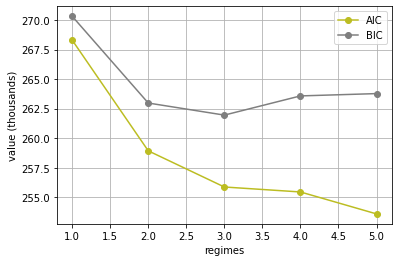

AIC: [268297.3965664  258926.0223941  255867.4440166  255446.87722138
 253589.57115158]
BIC: [270313.9396773  262971.20787456 261949.33803907 263573.5459583
 263769.0807754 ]


In [11]:
S_max = 5
S_grid = np.arange(1,S_max+1)
PLL_grid = np.zeros(S_max)
OLL_grid = np.zeros(S_max)
AIC_grid = np.zeros(S_max)
BIC_grid = np.zeros(S_max)

for S in S_grid:
    if S == 1:
        rsfm = fm_fit(r,F)
        PLL_grid[S-1] = rsfm.PLL_hist
        OLL_grid[S-1] = rsfm.OLL_hist
        AIC_grid[S-1] = rsfm.AIC
        BIC_grid[S-1] = rsfm.BIC
    else:
        N_ITER = 50
        N_INIT = 5
        rsfm = rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)
        PLL_grid[S-1] = rsfm.PLL_hist[-1]
        OLL_grid[S-1] = rsfm.OLL_hist[-1]
        AIC_grid[S-1] = rsfm.AIC
        BIC_grid[S-1] = rsfm.BIC
        
plt.plot(S_grid,AIC_grid/1000,marker='o',color='C8',label='AIC')
plt.plot(S_grid,BIC_grid/1000,marker='o',color='C7',label='BIC')
plt.xlabel("regimes")
plt.ylabel("value (thousands)")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\IC-rsfm.png")
plt.show()

print("AIC:",AIC_grid)
print("BIC:",BIC_grid)

init 1/5, iter 1/50 --- 0.8257937431335449 seconds
init 1/5, iter 2/50 --- 0.7629597187042236 seconds
init 1/5, iter 3/50 --- 0.8676791191101074 seconds
init 1/5, iter 4/50 --- 0.9594354629516602 seconds
init 1/5, iter 5/50 --- 0.8527541160583496 seconds
init 1/5, iter 6/50 --- 0.866682767868042 seconds
init 1/5, iter 7/50 --- 0.8397557735443115 seconds
init 1/5, iter 8/50 --- 0.8467357158660889 seconds
init 1/5, iter 9/50 --- 0.8567101955413818 seconds
init 1/5, iter 10/50 --- 0.9195413589477539 seconds
init 1/5, iter 11/50 --- 0.9005892276763916 seconds
init 1/5, iter 12/50 --- 0.7889256477355957 seconds
init 1/5, iter 13/50 --- 0.816779613494873 seconds
init 1/5, iter 14/50 --- 0.8906192779541016 seconds
init 1/5, iter 15/50 --- 0.8656854629516602 seconds
init 1/5, iter 16/50 --- 0.8975999355316162 seconds
init 1/5, iter 17/50 --- 0.8886244297027588 seconds
init 1/5, iter 18/50 --- 0.8577067852020264 seconds
init 1/5, iter 19/50 --- 0.9105656147003174 seconds
init 1/5, iter 20/50 --

init 4/5, iter 7/50 --- 0.8966038227081299 seconds
init 4/5, iter 8/50 --- 0.8776524066925049 seconds
init 4/5, iter 9/50 --- 0.9115636348724365 seconds
init 4/5, iter 10/50 --- 0.9235310554504395 seconds
init 4/5, iter 11/50 --- 0.9275195598602295 seconds
init 4/5, iter 12/50 --- 0.845740556716919 seconds
init 4/5, iter 13/50 --- 0.8826379776000977 seconds
init 4/5, iter 14/50 --- 0.8457396030426025 seconds
init 4/5, iter 15/50 --- 0.7888908386230469 seconds
init 4/5, iter 16/50 --- 0.826789379119873 seconds
init 4/5, iter 17/50 --- 0.8706719875335693 seconds
init 4/5, iter 18/50 --- 0.8626937866210938 seconds
init 4/5, iter 19/50 --- 0.915553092956543 seconds
init 4/5, iter 20/50 --- 0.9704043865203857 seconds
init 4/5, iter 21/50 --- 0.930511474609375 seconds
init 4/5, iter 22/50 --- 0.9464700222015381 seconds
init 4/5, iter 23/50 --- 0.9185440540313721 seconds
init 4/5, iter 24/50 --- 0.9783849716186523 seconds
init 4/5, iter 25/50 --- 0.8776531219482422 seconds
init 4/5, iter 26/5

init 2/5, iter 12/50 --- 1.6007204055786133 seconds
init 2/5, iter 13/50 --- 1.5548431873321533 seconds
init 2/5, iter 14/50 --- 1.4870245456695557 seconds
init 2/5, iter 15/50 --- 1.4760537147521973 seconds
init 2/5, iter 16/50 --- 1.354379653930664 seconds
init 2/5, iter 17/50 --- 1.4531145095825195 seconds
init 2/5, iter 18/50 --- 1.5368905067443848 seconds
init 2/5, iter 19/50 --- 1.3623580932617188 seconds
init 2/5, iter 20/50 --- 1.4152162075042725 seconds
init 2/5, iter 21/50 --- 1.4680755138397217 seconds
init 2/5, iter 22/50 --- 1.4012534618377686 seconds
init 2/5, iter 23/50 --- 1.4092330932617188 seconds
init 2/5, iter 24/50 --- 1.4241924285888672 seconds
init 2/5, iter 25/50 --- 1.419205665588379 seconds
init 2/5, iter 26/50 --- 1.294539213180542 seconds
init 2/5, iter 27/50 --- 1.372331142425537 seconds
init 2/5, iter 28/50 --- 1.3813071250915527 seconds
init 2/5, iter 29/50 --- 1.42518949508667 seconds
init 2/5, iter 30/50 --- 1.3513877391815186 seconds
init 2/5, iter 31/

init 5/5, iter 18/50 --- 1.635627031326294 seconds
init 5/5, iter 19/50 --- 1.6745238304138184 seconds
init 5/5, iter 20/50 --- 1.4660801887512207 seconds
init 5/5, iter 21/50 --- 1.5199363231658936 seconds
init 5/5, iter 22/50 --- 1.4979946613311768 seconds
init 5/5, iter 23/50 --- 1.630640983581543 seconds
init 5/5, iter 24/50 --- 1.4670789241790771 seconds
init 5/5, iter 25/50 --- 1.4391520023345947 seconds
init 5/5, iter 26/50 --- 1.4720642566680908 seconds
init 5/5, iter 27/50 --- 1.6226623058319092 seconds
init 5/5, iter 28/50 --- 1.4770519733428955 seconds
init 5/5, iter 29/50 --- 1.5478603839874268 seconds
init 5/5, iter 30/50 --- 1.3932757377624512 seconds
init 5/5, iter 31/50 --- 1.3972654342651367 seconds
init 5/5, iter 32/50 --- 1.4112255573272705 seconds
init 5/5, iter 33/50 --- 1.4571056365966797 seconds
init 5/5, iter 34/50 --- 1.3663461208343506 seconds
init 5/5, iter 35/50 --- 1.3982617855072021 seconds
init 5/5, iter 36/50 --- 1.3314399719238281 seconds
init 5/5, iter

init 3/5, iter 25/50 --- 2.221061944961548 seconds
init 3/5, iter 26/50 --- 2.023589849472046 seconds
init 3/5, iter 27/50 --- 2.0664756298065186 seconds
init 3/5, iter 28/50 --- 2.128310203552246 seconds
init 3/5, iter 29/50 --- 2.154240369796753 seconds
init 3/5, iter 30/50 --- 2.180171251296997 seconds
init 3/5, iter 31/50 --- 2.1971263885498047 seconds
init 3/5, iter 32/50 --- 2.131335973739624 seconds
init 3/5, iter 33/50 --- 2.2509818077087402 seconds
init 3/5, iter 34/50 --- 2.2021143436431885 seconds
init 3/5, iter 35/50 --- 2.118335485458374 seconds
init 3/5, iter 36/50 --- 2.122326374053955 seconds
init 3/5, iter 37/50 --- 2.010624885559082 seconds
init 3/5, iter 38/50 --- 2.26690936088562 seconds
init 3/5, iter 39/50 --- 2.223055601119995 seconds
init 3/5, iter 40/50 --- 2.2689342498779297 seconds
init 3/5, iter 41/50 --- 2.263947010040283 seconds
init 3/5, iter 42/50 --- 2.454437494277954 seconds
init 3/5, iter 43/50 --- 2.4753825664520264 seconds
init 3/5, iter 44/50 --- 2

init 1/5, iter 33/50 --- 3.0059611797332764 seconds
init 1/5, iter 34/50 --- 3.088776111602783 seconds
init 1/5, iter 35/50 --- 3.119659900665283 seconds
init 1/5, iter 36/50 --- 3.1106832027435303 seconds
init 1/5, iter 37/50 --- 3.6552302837371826 seconds
init 1/5, iter 38/50 --- 3.4767024517059326 seconds
init 1/5, iter 39/50 --- 3.566465139389038 seconds
init 1/5, iter 40/50 --- 3.6632416248321533 seconds
init 1/5, iter 41/50 --- 3.669189929962158 seconds
init 1/5, iter 42/50 --- 3.4348530769348145 seconds
init 1/5, iter 43/50 --- 3.399874687194824 seconds
init 1/5, iter 44/50 --- 3.3749771118164062 seconds
init 1/5, iter 45/50 --- 3.3690297603607178 seconds
init 1/5, iter 46/50 --- 3.145589828491211 seconds
init 1/5, iter 47/50 --- 2.990006446838379 seconds
init 1/5, iter 48/50 --- 3.2104532718658447 seconds
init 1/5, iter 49/50 --- 3.218355178833008 seconds
init 1/5, iter 50/50 --- 3.1226515769958496 seconds
better init found with log-likelihood -301.40921682469894
init 1/5 --- 1

init 4/5, iter 40/50 --- 3.5884478092193604 seconds
init 4/5, iter 41/50 --- 3.545551300048828 seconds
init 4/5, iter 42/50 --- 3.7500064373016357 seconds
init 4/5, iter 43/50 --- 3.533552408218384 seconds
init 4/5, iter 44/50 --- 3.321120023727417 seconds
init 4/5, iter 45/50 --- 3.181493043899536 seconds
init 4/5, iter 46/50 --- 3.087745428085327 seconds
init 4/5, iter 47/50 --- 3.182493209838867 seconds
init 4/5, iter 48/50 --- 3.275242805480957 seconds
init 4/5, iter 49/50 --- 3.1944594383239746 seconds
init 4/5, iter 50/50 --- 3.0947604179382324 seconds
better init found with log-likelihood -300.9970355478934
init 4/5 --- 163.28306794166565 seconds

init 5/5, iter 1/50 --- 3.1785004138946533 seconds
init 5/5, iter 2/50 --- 3.3320891857147217 seconds
init 5/5, iter 3/50 --- 3.1246449947357178 seconds
init 5/5, iter 4/50 --- 3.2882072925567627 seconds
init 5/5, iter 5/50 --- 3.310153007507324 seconds
init 5/5, iter 6/50 --- 3.080799102783203 seconds
init 5/5, iter 7/50 --- 3.1465539

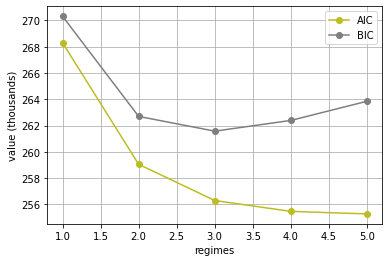

AIC: [268297.3965664  259054.52050035 256299.85683048 255472.86903491
 255279.52764694]
BIC: [270313.9396773  262696.39735864 261575.1336086  262389.61190529
 263845.80278204]


In [12]:
S_max = 5
S_grid_a = np.arange(1,S_max+1)
PLL_grid_a = np.zeros(S_max)
OLL_grid_a = np.zeros(S_max)
AIC_grid_a = np.zeros(S_max)
BIC_grid_a = np.zeros(S_max)

for S in S_grid_a:
    if S == 1:
        α_rsfm = fm_fit(r,F)
        PLL_grid_a[S-1] = α_rsfm.PLL_hist
        OLL_grid_a[S-1] = α_rsfm.OLL_hist
        AIC_grid_a[S-1] = α_rsfm.AIC
        BIC_grid_a[S-1] = α_rsfm.BIC
    else:
        N_ITER = 50
        N_INIT = 5
        α_rsfm = α_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)
        PLL_grid_a[S-1] = α_rsfm.PLL_hist[-1]
        OLL_grid_a[S-1] = α_rsfm.OLL_hist[-1]
        AIC_grid_a[S-1] = α_rsfm.AIC
        BIC_grid_a[S-1] = α_rsfm.BIC
        
plt.plot(S_grid_a,AIC_grid_a/1000,marker='o',color='C8',label='AIC')
plt.plot(S_grid_a,BIC_grid_a/1000,marker='o',color='C7',label='BIC')
plt.xlabel("regimes")
plt.ylabel("value (thousands)")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\IC-rsfm-a.png")
plt.show()

print("AIC:",AIC_grid_a)
print("BIC:",BIC_grid_a)

init 1/5, iter 1/50 --- 0.48673295974731445 seconds
init 1/5, iter 2/50 --- 0.5165998935699463 seconds
init 1/5, iter 3/50 --- 0.5794582366943359 seconds
init 1/5, iter 4/50 --- 0.5415546894073486 seconds
init 1/5, iter 5/50 --- 0.4936549663543701 seconds
init 1/5, iter 6/50 --- 0.4797210693359375 seconds
init 1/5, iter 7/50 --- 0.5445771217346191 seconds
init 1/5, iter 8/50 --- 0.46476006507873535 seconds
init 1/5, iter 9/50 --- 0.49866318702697754 seconds
init 1/5, iter 10/50 --- 0.4657444953918457 seconds
init 1/5, iter 11/50 --- 0.4597351551055908 seconds
init 1/5, iter 12/50 --- 0.43483805656433105 seconds
init 1/5, iter 13/50 --- 0.4857370853424072 seconds
init 1/5, iter 14/50 --- 0.4786849021911621 seconds
init 1/5, iter 15/50 --- 0.5126633644104004 seconds
init 1/5, iter 16/50 --- 0.5046494007110596 seconds
init 1/5, iter 17/50 --- 0.469710111618042 seconds
init 1/5, iter 18/50 --- 0.48972415924072266 seconds
init 1/5, iter 19/50 --- 0.5465073585510254 seconds
init 1/5, iter 20

init 4/5, iter 5/50 --- 0.46774888038635254 seconds
init 4/5, iter 6/50 --- 0.5096728801727295 seconds
init 4/5, iter 7/50 --- 0.4876976013183594 seconds
init 4/5, iter 8/50 --- 0.4967045783996582 seconds
init 4/5, iter 9/50 --- 0.548565149307251 seconds
init 4/5, iter 10/50 --- 0.49866414070129395 seconds
init 4/5, iter 11/50 --- 0.4916830062866211 seconds
init 4/5, iter 12/50 --- 0.5266251564025879 seconds
init 4/5, iter 13/50 --- 0.5106019973754883 seconds
init 4/5, iter 14/50 --- 0.5585060119628906 seconds
init 4/5, iter 15/50 --- 0.5196466445922852 seconds
init 4/5, iter 16/50 --- 0.4248642921447754 seconds
init 4/5, iter 17/50 --- 0.4727356433868408 seconds
init 4/5, iter 18/50 --- 0.502690315246582 seconds
init 4/5, iter 19/50 --- 0.49766969680786133 seconds
init 4/5, iter 20/50 --- 0.45179033279418945 seconds
init 4/5, iter 21/50 --- 0.45977091789245605 seconds
init 4/5, iter 22/50 --- 0.488694429397583 seconds
init 4/5, iter 23/50 --- 0.48470473289489746 seconds
init 4/5, iter

init 2/5, iter 9/50 --- 0.9195394515991211 seconds
init 2/5, iter 10/50 --- 0.9005935192108154 seconds
init 2/5, iter 11/50 --- 0.9554443359375 seconds
init 2/5, iter 12/50 --- 0.8457725048065186 seconds
init 2/5, iter 13/50 --- 0.85172438621521 seconds
init 2/5, iter 14/50 --- 0.795905590057373 seconds
init 2/5, iter 15/50 --- 0.840752363204956 seconds
init 2/5, iter 16/50 --- 0.8227667808532715 seconds
init 2/5, iter 17/50 --- 0.8497278690338135 seconds
init 2/5, iter 18/50 --- 0.7460386753082275 seconds
init 2/5, iter 19/50 --- 0.8427789211273193 seconds
init 2/5, iter 20/50 --- 0.8228018283843994 seconds
init 2/5, iter 21/50 --- 0.8437423706054688 seconds
init 2/5, iter 22/50 --- 0.7978987693786621 seconds
init 2/5, iter 23/50 --- 0.8068740367889404 seconds
init 2/5, iter 24/50 --- 0.8327412605285645 seconds
init 2/5, iter 25/50 --- 0.8188109397888184 seconds
init 2/5, iter 26/50 --- 0.7998607158660889 seconds
init 2/5, iter 27/50 --- 0.8018925189971924 seconds
init 2/5, iter 28/50

init 5/5, iter 15/50 --- 0.7629616260528564 seconds
init 5/5, iter 16/50 --- 0.8317759037017822 seconds
init 5/5, iter 17/50 --- 0.8078420162200928 seconds
init 5/5, iter 18/50 --- 0.7540180683135986 seconds
init 5/5, iter 19/50 --- 0.8407526016235352 seconds
init 5/5, iter 20/50 --- 0.8038492202758789 seconds
init 5/5, iter 21/50 --- 0.7978670597076416 seconds
init 5/5, iter 22/50 --- 0.8457069396972656 seconds
init 5/5, iter 23/50 --- 0.7919154167175293 seconds
init 5/5, iter 24/50 --- 0.7739322185516357 seconds
init 5/5, iter 25/50 --- 0.8048501014709473 seconds
init 5/5, iter 26/50 --- 0.7529516220092773 seconds
init 5/5, iter 27/50 --- 0.8108317852020264 seconds
init 5/5, iter 28/50 --- 0.8168165683746338 seconds
init 5/5, iter 29/50 --- 0.778916597366333 seconds
init 5/5, iter 30/50 --- 0.7918822765350342 seconds
init 5/5, iter 31/50 --- 0.8008584976196289 seconds
init 5/5, iter 32/50 --- 0.7819092273712158 seconds
init 5/5, iter 33/50 --- 0.812835693359375 seconds
init 5/5, iter

init 3/5, iter 18/50 --- 1.2755913734436035 seconds
init 3/5, iter 19/50 --- 1.315542459487915 seconds
init 3/5, iter 20/50 --- 1.2796123027801514 seconds
init 3/5, iter 21/50 --- 1.339385986328125 seconds
init 3/5, iter 22/50 --- 1.3214669227600098 seconds
init 3/5, iter 23/50 --- 1.2995257377624512 seconds
init 3/5, iter 24/50 --- 1.338423490524292 seconds
init 3/5, iter 25/50 --- 1.3524184226989746 seconds
init 3/5, iter 26/50 --- 1.3962349891662598 seconds
init 3/5, iter 27/50 --- 1.3055431842803955 seconds
init 3/5, iter 28/50 --- 1.300487756729126 seconds
init 3/5, iter 29/50 --- 1.256676197052002 seconds
init 3/5, iter 30/50 --- 1.2616195678710938 seconds
init 3/5, iter 31/50 --- 1.4361615180969238 seconds
init 3/5, iter 32/50 --- 1.5179412364959717 seconds
init 3/5, iter 33/50 --- 1.4311695098876953 seconds
init 3/5, iter 34/50 --- 1.5937399864196777 seconds
init 3/5, iter 35/50 --- 1.361393928527832 seconds
init 3/5, iter 36/50 --- 1.5169122219085693 seconds
init 3/5, iter 37/

init 1/5, iter 24/50 --- 2.1233255863189697 seconds
init 1/5, iter 25/50 --- 2.1422691345214844 seconds
init 1/5, iter 26/50 --- 2.2180652618408203 seconds
init 1/5, iter 27/50 --- 2.1532413959503174 seconds
init 1/5, iter 28/50 --- 2.238022804260254 seconds
init 1/5, iter 29/50 --- 2.1332907676696777 seconds
init 1/5, iter 30/50 --- 2.087456703186035 seconds
init 1/5, iter 31/50 --- 2.3726232051849365 seconds
init 1/5, iter 32/50 --- 2.1452994346618652 seconds
init 1/5, iter 33/50 --- 2.309866189956665 seconds
init 1/5, iter 34/50 --- 2.1729660034179688 seconds
init 1/5, iter 35/50 --- 2.171227216720581 seconds
init 1/5, iter 36/50 --- 2.1961214542388916 seconds
init 1/5, iter 37/50 --- 2.21304988861084 seconds
init 1/5, iter 38/50 --- 2.1861910820007324 seconds
init 1/5, iter 39/50 --- 2.3736183643341064 seconds
init 1/5, iter 40/50 --- 2.3178372383117676 seconds
init 1/5, iter 41/50 --- 2.431499481201172 seconds
init 1/5, iter 42/50 --- 2.4464595317840576 seconds
init 1/5, iter 43/5

init 4/5, iter 29/50 --- 2.3257815837860107 seconds
init 4/5, iter 30/50 --- 2.414546012878418 seconds
init 4/5, iter 31/50 --- 2.149286985397339 seconds
init 4/5, iter 32/50 --- 2.1919596195220947 seconds
init 4/5, iter 33/50 --- 2.221072196960449 seconds
init 4/5, iter 34/50 --- 2.1512486934661865 seconds
init 4/5, iter 35/50 --- 2.250983476638794 seconds
init 4/5, iter 36/50 --- 2.1163065433502197 seconds
init 4/5, iter 37/50 --- 2.2151122093200684 seconds
init 4/5, iter 38/50 --- 2.245997428894043 seconds
init 4/5, iter 39/50 --- 2.0923714637756348 seconds
init 4/5, iter 40/50 --- 2.1682376861572266 seconds
init 4/5, iter 41/50 --- 2.1592273712158203 seconds
init 4/5, iter 42/50 --- 2.1802055835723877 seconds
init 4/5, iter 43/50 --- 2.151249647140503 seconds
init 4/5, iter 44/50 --- 2.2410099506378174 seconds
init 4/5, iter 45/50 --- 2.331768035888672 seconds
init 4/5, iter 46/50 --- 2.3646440505981445 seconds
init 4/5, iter 47/50 --- 2.303872585296631 seconds
init 4/5, iter 48/50

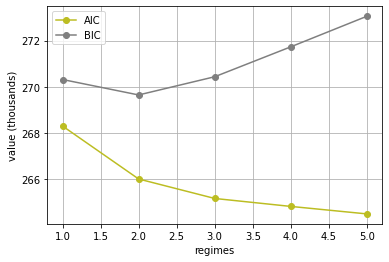

AIC: [268297.3965664  266003.04082751 265159.30905975 264814.69581809
 264489.74306635]
BIC: [270313.9396773  269644.91768579 270434.58583787 271731.43868847
 273056.01820145]


In [13]:
S_max = 5
S_grid_s = np.arange(1,S_max+1)
PLL_grid_s = np.zeros(S_max)
OLL_grid_s = np.zeros(S_max)
AIC_grid_s = np.zeros(S_max)
BIC_grid_s = np.zeros(S_max)

for S in S_grid_s:
    if S == 1: 
        σ_rsfm = fm_fit(r,F)
        PLL_grid_s[S-1] = σ_rsfm.PLL_hist
        OLL_grid_s[S-1] = σ_rsfm.OLL_hist
        AIC_grid_s[S-1] = σ_rsfm.AIC
        BIC_grid_s[S-1] = σ_rsfm.BIC
    else:
        N_ITER = 50
        N_INIT = 5
        σ_rsfm = σ_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)
        PLL_grid_s[S-1] = σ_rsfm.PLL_hist[-1]
        OLL_grid_s[S-1] = σ_rsfm.OLL_hist[-1]
        AIC_grid_s[S-1] = σ_rsfm.AIC
        BIC_grid_s[S-1] = σ_rsfm.BIC
        
plt.plot(S_grid_s,AIC_grid_s/1000,marker='o',color='C8',label='AIC')
plt.plot(S_grid_s,BIC_grid_s/1000,marker='o',color='C7',label='BIC')
plt.xlabel("regimes")
plt.ylabel("value (thousands)")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\IC-rsfm-s.png")
plt.show()

print("AIC:",AIC_grid_s)
print("BIC:",BIC_grid_s)

init 1/5, iter 1/50 --- 1.005314826965332 seconds
init 1/5, iter 2/50 --- 1.0801100730895996 seconds
init 1/5, iter 3/50 --- 0.9943406581878662 seconds
init 1/5, iter 4/50 --- 1.0851004123687744 seconds
init 1/5, iter 5/50 --- 1.0402181148529053 seconds
init 1/5, iter 6/50 --- 0.9963369369506836 seconds
init 1/5, iter 7/50 --- 1.0023179054260254 seconds
init 1/5, iter 8/50 --- 0.9863615036010742 seconds
init 1/5, iter 9/50 --- 0.9674127101898193 seconds
init 1/5, iter 10/50 --- 0.9454751014709473 seconds
init 1/5, iter 11/50 --- 0.9355001449584961 seconds
init 1/5, iter 12/50 --- 0.9165499210357666 seconds
init 1/5, iter 13/50 --- 0.8746285438537598 seconds
init 1/5, iter 14/50 --- 0.9554443359375 seconds
init 1/5, iter 15/50 --- 0.9195427894592285 seconds
init 1/5, iter 16/50 --- 0.99833083152771 seconds
init 1/5, iter 17/50 --- 1.0122935771942139 seconds
init 1/5, iter 18/50 --- 1.0063097476959229 seconds
init 1/5, iter 19/50 --- 1.0302448272705078 seconds
init 1/5, iter 20/50 --- 0.

init 4/5, iter 7/50 --- 0.9305119514465332 seconds
init 4/5, iter 8/50 --- 0.9105668067932129 seconds
init 4/5, iter 9/50 --- 0.9584362506866455 seconds
init 4/5, iter 10/50 --- 0.9963357448577881 seconds
init 4/5, iter 11/50 --- 1.0312433242797852 seconds
init 4/5, iter 12/50 --- 0.9933438301086426 seconds
init 4/5, iter 13/50 --- 0.9065771102905273 seconds
init 4/5, iter 14/50 --- 0.8916182518005371 seconds
init 4/5, iter 15/50 --- 0.9275195598602295 seconds
init 4/5, iter 16/50 --- 0.920541524887085 seconds
init 4/5, iter 17/50 --- 0.9105651378631592 seconds
init 4/5, iter 18/50 --- 0.7868945598602295 seconds
init 4/5, iter 19/50 --- 0.8447418212890625 seconds
init 4/5, iter 20/50 --- 0.9255833625793457 seconds
init 4/5, iter 21/50 --- 0.881643533706665 seconds
init 4/5, iter 22/50 --- 0.8697085380554199 seconds
init 4/5, iter 23/50 --- 0.9195051193237305 seconds
init 4/5, iter 24/50 --- 0.90557861328125 seconds
init 4/5, iter 25/50 --- 0.9055798053741455 seconds
init 4/5, iter 26/5

init 2/5, iter 12/50 --- 1.401254415512085 seconds
init 2/5, iter 13/50 --- 1.3892841339111328 seconds
init 2/5, iter 14/50 --- 1.3882884979248047 seconds
init 2/5, iter 15/50 --- 1.354379415512085 seconds
init 2/5, iter 16/50 --- 1.3992934226989746 seconds
init 2/5, iter 17/50 --- 1.3533804416656494 seconds
init 2/5, iter 18/50 --- 1.4890522956848145 seconds
init 2/5, iter 19/50 --- 1.38529634475708 seconds
init 2/5, iter 20/50 --- 1.3484292030334473 seconds
init 2/5, iter 21/50 --- 1.4600627422332764 seconds
init 2/5, iter 22/50 --- 1.3374245166778564 seconds
init 2/5, iter 23/50 --- 1.3673436641693115 seconds
init 2/5, iter 24/50 --- 1.366347074508667 seconds
init 2/5, iter 25/50 --- 1.402252197265625 seconds
init 2/5, iter 26/50 --- 1.2785818576812744 seconds
init 2/5, iter 27/50 --- 1.396265983581543 seconds
init 2/5, iter 28/50 --- 1.3703374862670898 seconds
init 2/5, iter 29/50 --- 1.4551091194152832 seconds
init 2/5, iter 30/50 --- 1.3833034038543701 seconds
init 2/5, iter 31/5

init 5/5, iter 17/50 --- 1.4770498275756836 seconds
init 5/5, iter 18/50 --- 1.3872904777526855 seconds
init 5/5, iter 19/50 --- 1.466078758239746 seconds
init 5/5, iter 20/50 --- 1.410231113433838 seconds
init 5/5, iter 21/50 --- 1.4291772842407227 seconds
init 5/5, iter 22/50 --- 1.3912804126739502 seconds
init 5/5, iter 23/50 --- 1.3813073635101318 seconds
init 5/5, iter 24/50 --- 1.3174784183502197 seconds
init 5/5, iter 25/50 --- 1.3613591194152832 seconds
init 5/5, iter 26/50 --- 1.4032487869262695 seconds
init 5/5, iter 27/50 --- 1.3663828372955322 seconds
init 5/5, iter 28/50 --- 1.3294451236724854 seconds
init 5/5, iter 29/50 --- 1.3573710918426514 seconds
init 5/5, iter 30/50 --- 1.3364284038543701 seconds
init 5/5, iter 31/50 --- 1.3882901668548584 seconds
init 5/5, iter 32/50 --- 1.3015222549438477 seconds
init 5/5, iter 33/50 --- 1.4421420097351074 seconds
init 5/5, iter 34/50 --- 1.4720666408538818 seconds
init 5/5, iter 35/50 --- 1.4312069416046143 seconds
init 5/5, iter

init 3/5, iter 24/50 --- 2.3537099361419678 seconds
init 3/5, iter 25/50 --- 2.5282721519470215 seconds
init 3/5, iter 26/50 --- 2.190110921859741 seconds
init 3/5, iter 27/50 --- 2.3357579708099365 seconds
init 3/5, iter 28/50 --- 2.104372262954712 seconds
init 3/5, iter 29/50 --- 2.1273467540740967 seconds
init 3/5, iter 30/50 --- 2.109346628189087 seconds
init 3/5, iter 31/50 --- 2.1103594303131104 seconds
init 3/5, iter 32/50 --- 2.0973920822143555 seconds
init 3/5, iter 33/50 --- 2.1452629566192627 seconds
init 3/5, iter 34/50 --- 2.187154769897461 seconds
init 3/5, iter 35/50 --- 2.161259889602661 seconds
init 3/5, iter 36/50 --- 2.029536724090576 seconds
init 3/5, iter 37/50 --- 2.1523213386535645 seconds
init 3/5, iter 38/50 --- 2.183128595352173 seconds
init 3/5, iter 39/50 --- 2.1263136863708496 seconds
init 3/5, iter 40/50 --- 2.061490058898926 seconds
init 3/5, iter 41/50 --- 2.15024995803833 seconds
init 3/5, iter 42/50 --- 2.1582303047180176 seconds
init 3/5, iter 43/50 -

init 1/5, iter 32/50 --- 3.212409496307373 seconds
init 1/5, iter 33/50 --- 3.0259106159210205 seconds
init 1/5, iter 34/50 --- 3.2064297199249268 seconds
init 1/5, iter 35/50 --- 3.111679792404175 seconds
init 1/5, iter 36/50 --- 3.1455905437469482 seconds
init 1/5, iter 37/50 --- 3.1236507892608643 seconds
init 1/5, iter 38/50 --- 3.194490671157837 seconds
init 1/5, iter 39/50 --- 3.178502321243286 seconds
init 1/5, iter 40/50 --- 3.1485812664031982 seconds
init 1/5, iter 41/50 --- 3.070791482925415 seconds
init 1/5, iter 42/50 --- 3.139605760574341 seconds
init 1/5, iter 43/50 --- 3.1176652908325195 seconds
init 1/5, iter 44/50 --- 3.2114129066467285 seconds
init 1/5, iter 45/50 --- 3.2883479595184326 seconds
init 1/5, iter 46/50 --- 3.3480494022369385 seconds
init 1/5, iter 47/50 --- 3.271253824234009 seconds
init 1/5, iter 48/50 --- 2.945126533508301 seconds
init 1/5, iter 49/50 --- 3.4029033184051514 seconds
init 1/5, iter 50/50 --- 3.5345511436462402 seconds
better init found wi

init 4/5, iter 36/50 --- 3.375974416732788 seconds
init 4/5, iter 37/50 --- 3.2812275886535645 seconds
init 4/5, iter 38/50 --- 3.058821678161621 seconds
init 4/5, iter 39/50 --- 3.3590199947357178 seconds
init 4/5, iter 40/50 --- 3.1465871334075928 seconds
init 4/5, iter 41/50 --- 3.0009782314300537 seconds
init 4/5, iter 42/50 --- 3.3969173431396484 seconds
init 4/5, iter 43/50 --- 3.1376116275787354 seconds
init 4/5, iter 44/50 --- 3.232358694076538 seconds
init 4/5, iter 45/50 --- 3.191467761993408 seconds
init 4/5, iter 46/50 --- 3.0652716159820557 seconds
init 4/5, iter 47/50 --- 3.20845627784729 seconds
init 4/5, iter 48/50 --- 3.3180952072143555 seconds
init 4/5, iter 49/50 --- 3.246321201324463 seconds
init 4/5, iter 50/50 --- 3.0588221549987793 seconds
init 4/5 --- 162.1811864376068 seconds

init 5/5, iter 1/50 --- 3.2702548503875732 seconds
init 5/5, iter 2/50 --- 3.566465377807617 seconds
init 5/5, iter 3/50 --- 3.6652328968048096 seconds
init 5/5, iter 4/50 --- 3.550508022

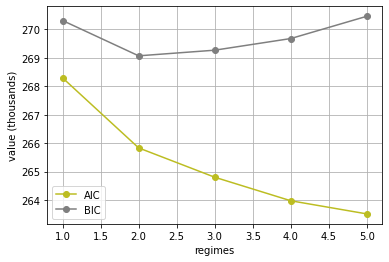

AIC: [268297.3965664  265833.21345006 264801.64775318 263973.30616823
 263511.10231994]
BIC: [270313.9396773  269071.78168617 269270.30728693 269680.12317207
 270464.14296632]


In [14]:
S_max = 5
S_grid_as = np.arange(1,S_max+1)
PLL_grid_as = np.zeros(S_max)
OLL_grid_as = np.zeros(S_max)
AIC_grid_as = np.zeros(S_max)
BIC_grid_as = np.zeros(S_max)

for S in S_grid_as:
    if S == 1:
        ασ_rsfm = fm_fit(r,F)
        PLL_grid_as[S-1] = ασ_rsfm.PLL_hist
        OLL_grid_as[S-1] = ασ_rsfm.OLL_hist
        AIC_grid_as[S-1] = ασ_rsfm.AIC
        BIC_grid_as[S-1] = ασ_rsfm.BIC
    else:
        N_ITER = 50
        N_INIT = 5
        ασ_rsfm = ασ_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)
        PLL_grid_as[S-1] = ασ_rsfm.PLL_hist[-1]
        OLL_grid_as[S-1] = ασ_rsfm.OLL_hist[-1]
        AIC_grid_as[S-1] = ασ_rsfm.AIC
        BIC_grid_as[S-1] = ασ_rsfm.BIC
        
plt.plot(S_grid_as,AIC_grid_as/1000,marker='o',color='C8',label='AIC')
plt.plot(S_grid_as,BIC_grid_as/1000,marker='o',color='C7',label='BIC')
plt.xlabel("regimes")
plt.ylabel("value (thousands)")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\IC-rsfm-as.png")
plt.show()

print("AIC:",AIC_grid_as)
print("BIC:",BIC_grid_as) 

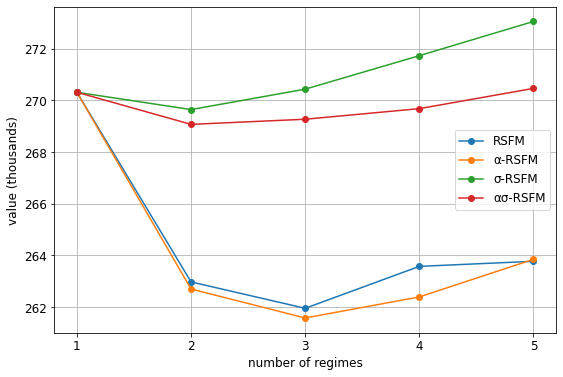

In [38]:
plt.figure(figsize=(9,6))
plt.plot(S_grid,BIC_grid/1000,marker='o',label='RSFM')
plt.plot(S_grid,BIC_grid_a/1000,marker='o',label='α-RSFM')
plt.plot(S_grid,BIC_grid_s/1000,marker='o',label='σ-RSFM')
plt.plot(S_grid,BIC_grid_as/1000,marker='o',label='ασ-RSFM')
plt.xlabel("number of regimes",fontsize=12)
plt.xticks(S_grid,fontsize=12)
plt.ylabel("value (thousands)",fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12,loc='right')
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\BIC.png")
plt.show()

In [16]:
T = r.shape[0]
N = r.shape[1]
M = F.shape[1]

for s in range(len(S_grid)):
    GLRT_st = 2*T*(OLL_grid[s]-OLL_grid_a[s])
    GLRT_df = s*N
    GLRT_pv = 1-st.chi2.cdf(GLRT_st,df=GLRT_df)
    print(GLRT_st,GLRT_df,GLRT_pv)

0.0 0 nan
328.4981062518633 100 0.0
832.4128138871882 200 0.0
625.9918135276736 300 0.0
2489.956495364855 400 0.0


# Inference

In [24]:
S = 2
N_INIT = 10

rsfm = rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)

# α_rsfm = α_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)

# σ_rsfm = σ_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)

# ασ_rsfm = ασ_rsfm_fit(r,F,S,N_ITER,N_INIT,verbose=2)

init 1/5, iter 1/50 --- 0.6861653327941895 seconds
init 1/5, iter 2/50 --- 0.6831738948822021 seconds
init 1/5, iter 3/50 --- 0.7340371608734131 seconds
init 1/5, iter 4/50 --- 0.7499949932098389 seconds
init 1/5, iter 5/50 --- 0.7868969440460205 seconds
init 1/5, iter 6/50 --- 0.8746614456176758 seconds
init 1/5, iter 7/50 --- 0.887627363204956 seconds
init 1/5, iter 8/50 --- 0.8138241767883301 seconds
init 1/5, iter 9/50 --- 0.7489964962005615 seconds
init 1/5, iter 10/50 --- 0.723067045211792 seconds
init 1/5, iter 11/50 --- 0.7569761276245117 seconds
init 1/5, iter 12/50 --- 0.7589716911315918 seconds
init 1/5, iter 13/50 --- 0.6831729412078857 seconds
init 1/5, iter 14/50 --- 0.7579741477966309 seconds
init 1/5, iter 15/50 --- 0.7170820236206055 seconds
init 1/5, iter 16/50 --- 0.6722047328948975 seconds
init 1/5, iter 17/50 --- 0.7041163444519043 seconds
init 1/5, iter 18/50 --- 0.7868964672088623 seconds
init 1/5, iter 19/50 --- 0.6941425800323486 seconds
init 1/5, iter 20/50 --

init 4/5, iter 5/50 --- 0.6053826808929443 seconds
init 4/5, iter 6/50 --- 0.6741962432861328 seconds
init 4/5, iter 7/50 --- 0.7101032733917236 seconds
init 4/5, iter 8/50 --- 0.6951396465301514 seconds
init 4/5, iter 9/50 --- 0.6791844367980957 seconds
init 4/5, iter 10/50 --- 0.6841704845428467 seconds
init 4/5, iter 11/50 --- 0.608375072479248 seconds
init 4/5, iter 12/50 --- 0.6522548198699951 seconds
init 4/5, iter 13/50 --- 0.6871988773345947 seconds
init 4/5, iter 14/50 --- 0.7340023517608643 seconds
init 4/5, iter 15/50 --- 0.8377604484558105 seconds
init 4/5, iter 16/50 --- 0.7868952751159668 seconds
init 4/5, iter 17/50 --- 0.6712074279785156 seconds
init 4/5, iter 18/50 --- 0.7968683242797852 seconds
init 4/5, iter 19/50 --- 0.8876283168792725 seconds
init 4/5, iter 20/50 --- 0.8287842273712158 seconds
init 4/5, iter 21/50 --- 0.8846352100372314 seconds
init 4/5, iter 22/50 --- 0.7908854484558105 seconds
init 4/5, iter 23/50 --- 0.8317756652832031 seconds
init 4/5, iter 24/

init 2/5, iter 10/50 --- 1.2486612796783447 seconds
init 2/5, iter 11/50 --- 1.3444056510925293 seconds
init 2/5, iter 12/50 --- 1.4950037002563477 seconds
init 2/5, iter 13/50 --- 1.3493921756744385 seconds
init 2/5, iter 14/50 --- 1.4610934257507324 seconds
init 2/5, iter 15/50 --- 1.5669922828674316 seconds
init 2/5, iter 16/50 --- 1.5089664459228516 seconds
init 2/5, iter 17/50 --- 1.3773179054260254 seconds
init 2/5, iter 18/50 --- 1.3912804126739502 seconds
init 2/5, iter 19/50 --- 1.5039801597595215 seconds
init 2/5, iter 20/50 --- 1.5468640327453613 seconds
init 2/5, iter 21/50 --- 1.2885549068450928 seconds
init 2/5, iter 22/50 --- 1.3124911785125732 seconds
init 2/5, iter 23/50 --- 1.3094992637634277 seconds
init 2/5, iter 24/50 --- 1.3354294300079346 seconds
init 2/5, iter 25/50 --- 1.3473985195159912 seconds
init 2/5, iter 26/50 --- 1.5438721179962158 seconds
init 2/5, iter 27/50 --- 1.5029802322387695 seconds
init 2/5, iter 28/50 --- 1.5388853549957275 seconds
init 2/5, it

init 5/5, iter 16/50 --- 1.5598278045654297 seconds
init 5/5, iter 17/50 --- 1.3872911930084229 seconds
init 5/5, iter 18/50 --- 1.424191951751709 seconds
init 5/5, iter 19/50 --- 1.5408799648284912 seconds
init 5/5, iter 20/50 --- 1.505974292755127 seconds
init 5/5, iter 21/50 --- 1.2725954055786133 seconds
init 5/5, iter 22/50 --- 1.441147804260254 seconds
init 5/5, iter 23/50 --- 1.344404935836792 seconds
init 5/5, iter 24/50 --- 1.387291669845581 seconds
init 5/5, iter 25/50 --- 1.366347074508667 seconds
init 5/5, iter 26/50 --- 1.4600963592529297 seconds
init 5/5, iter 27/50 --- 1.417210340499878 seconds
init 5/5, iter 28/50 --- 1.5289125442504883 seconds
init 5/5, iter 29/50 --- 1.414219617843628 seconds
init 5/5, iter 30/50 --- 1.4491260051727295 seconds
init 5/5, iter 31/50 --- 1.4690723419189453 seconds
init 5/5, iter 32/50 --- 1.5448698997497559 seconds
init 5/5, iter 33/50 --- 1.4700710773468018 seconds
init 5/5, iter 34/50 --- 1.523926019668579 seconds
init 5/5, iter 35/50 

init 3/5, iter 22/50 --- 0.6901545524597168 seconds
init 3/5, iter 23/50 --- 0.7240645885467529 seconds
init 3/5, iter 24/50 --- 0.8068418502807617 seconds
init 3/5, iter 25/50 --- 0.8008599281311035 seconds
init 3/5, iter 26/50 --- 0.7779192924499512 seconds
init 3/5, iter 27/50 --- 0.8447420597076416 seconds
init 3/5, iter 28/50 --- 0.7948751449584961 seconds
init 3/5, iter 29/50 --- 0.774930477142334 seconds
init 3/5, iter 30/50 --- 0.8776504993438721 seconds
init 3/5, iter 31/50 --- 0.8168184757232666 seconds
init 3/5, iter 32/50 --- 0.9125592708587646 seconds
init 3/5, iter 33/50 --- 0.8537170886993408 seconds
init 3/5, iter 34/50 --- 0.76894211769104 seconds
init 3/5, iter 35/50 --- 0.8098371028900146 seconds
init 3/5, iter 36/50 --- 0.8277847766876221 seconds
init 3/5, iter 37/50 --- 0.7729341983795166 seconds
init 3/5, iter 38/50 --- 0.8218011856079102 seconds
init 3/5, iter 39/50 --- 0.6572432518005371 seconds
init 3/5, iter 40/50 --- 0.7250597476959229 seconds
init 3/5, iter 

init 1/5, iter 26/50 --- 1.3045122623443604 seconds
init 1/5, iter 27/50 --- 1.377316951751709 seconds
init 1/5, iter 28/50 --- 1.2247264385223389 seconds
init 1/5, iter 29/50 --- 1.3553762435913086 seconds
init 1/5, iter 30/50 --- 1.3713335990905762 seconds
init 1/5, iter 31/50 --- 1.344404935836792 seconds
init 1/5, iter 32/50 --- 1.358368158340454 seconds
init 1/5, iter 33/50 --- 1.3294453620910645 seconds
init 1/5, iter 34/50 --- 1.377316951751709 seconds
init 1/5, iter 35/50 --- 1.2496585845947266 seconds
init 1/5, iter 36/50 --- 1.4291822910308838 seconds
init 1/5, iter 37/50 --- 1.3503894805908203 seconds
init 1/5, iter 38/50 --- 1.4690725803375244 seconds
init 1/5, iter 39/50 --- 1.445136308670044 seconds
init 1/5, iter 40/50 --- 1.3813064098358154 seconds
init 1/5, iter 41/50 --- 1.275589942932129 seconds
init 1/5, iter 42/50 --- 1.3503894805908203 seconds
init 1/5, iter 43/50 --- 1.4002580642700195 seconds
init 1/5, iter 44/50 --- 1.516944408416748 seconds
init 1/5, iter 45/5

init 4/5, iter 32/50 --- 1.368342399597168 seconds
init 4/5, iter 33/50 --- 1.3025169372558594 seconds
init 4/5, iter 34/50 --- 1.5578346252441406 seconds
init 4/5, iter 35/50 --- 1.581770896911621 seconds
init 4/5, iter 36/50 --- 1.4561073780059814 seconds
init 4/5, iter 37/50 --- 1.33443284034729 seconds
init 4/5, iter 38/50 --- 1.5279147624969482 seconds
init 4/5, iter 39/50 --- 1.3395717144012451 seconds
init 4/5, iter 40/50 --- 1.390282154083252 seconds
init 4/5, iter 41/50 --- 1.4999902248382568 seconds
init 4/5, iter 42/50 --- 1.410229206085205 seconds
init 4/5, iter 43/50 --- 1.3663475513458252 seconds
init 4/5, iter 44/50 --- 1.4421436786651611 seconds
init 4/5, iter 45/50 --- 1.6186723709106445 seconds
init 4/5, iter 46/50 --- 1.3952698707580566 seconds
init 4/5, iter 47/50 --- 1.5707995891571045 seconds
init 4/5, iter 48/50 --- 1.6136865615844727 seconds
init 4/5, iter 49/50 --- 1.4211995601654053 seconds
init 4/5, iter 50/50 --- 1.5408806800842285 seconds
better init found 

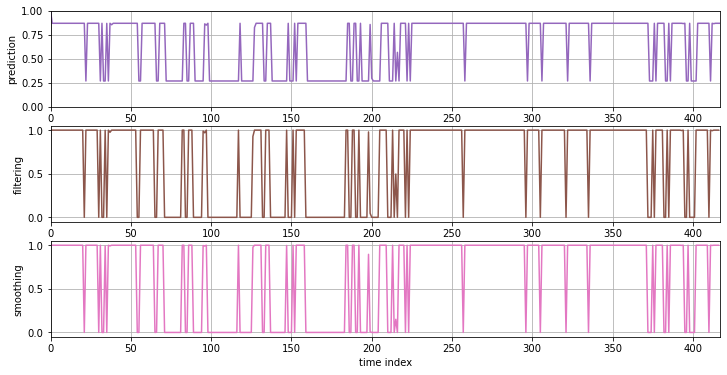

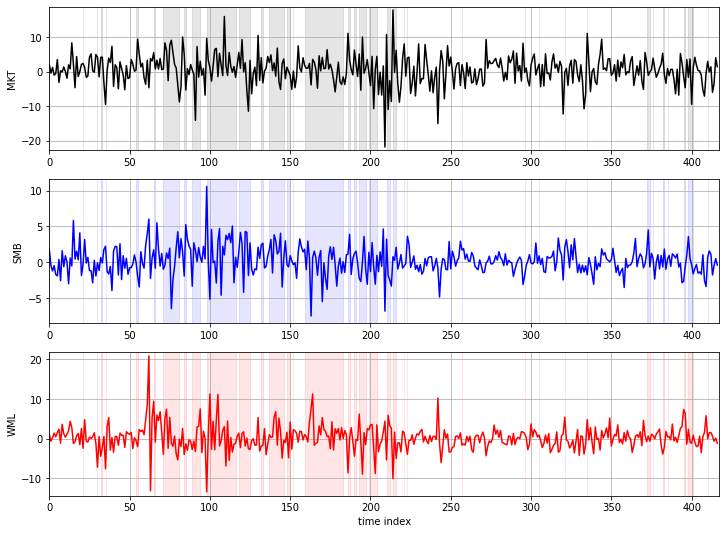

In [65]:
# assign states based on smoothing probabilities
rsfm_inf = rsfm.inference()
assigned_state = np.argmax(rsfm_inf.smoothing,axis=1)
assigned_state ^= 1
T0 = np.where(assigned_state==0)[0]
T1 = np.where(assigned_state==1)[0]

# plot prediction, filtering, and smoothing probabilities

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(1-rsfm_inf.prediction[:,0],color='C4')
plt.ylim(0,1)
plt.ylabel("prediction")
plt.xlim(0,T)
plt.grid()
plt.subplot(3,1,2)
plt.plot(1-rsfm_inf.filtering[:,0],color='C5')
plt.xlabel("time index")
plt.ylabel("filtering")
plt.xlim(0,T)
plt.grid()
plt.subplot(3,1,3)
plt.plot(1-rsfm_inf.smoothing[:,0],color='C6')
plt.xlabel("time index")
plt.ylabel("smoothing")
plt.xlim(0,T)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\inf-1.png")
plt.show()


# overlay assigned states on market factor
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(F[:,0],color='k')
plt.xlim(0,T)
plt.ylim(np.min(F[:,0])-1,np.max(F[:,0])+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='k',alpha=0.1)
plt.ylabel("MKT")
plt.grid()
plt.subplot(3,1,2)
plt.plot(F[:,1],color='b')
plt.xlim(0,T)
plt.ylim(np.min(F[:,1])-1,np.max(F[:,1])+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='b',alpha=0.1)
plt.ylabel("SMB")
plt.grid()
plt.subplot(3,1,3)
plt.plot(F[:,2],color='r')
plt.xlim(0,T)
plt.ylim(np.min(F[:,2])-1,np.max(F[:,2])+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='r',alpha=0.1)
plt.xlabel("time index")
plt.ylabel("WML")
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\inf-2.png")
plt.show()


In [45]:
np.mean(np.abs(rsfm.σ[0]))

8.480827623943775

In [44]:
np.mean(np.abs(rsfm.σ[1]))

4.718892726976642